In [2]:
# Import libraries
import numpy as np
import pandas as pd
import joblib, math, os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.pipeline import Pipeline
from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set random seed for reproducibility
RND_SEED = 42
np.random.seed(RND_SEED)

# Load data
df = pd.read_csv(r"C:\Users\user\Desktop\data_prediction\data_prediction_data.csv")
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (2000, 7)


,Parental Education,Previous Overall Marks,Class Attendance (%),Extracurricular Activities,Availability of Resources,Motivation Level,Study Hours per Week
0,Bachelor,69,64.610087,Yes,No,3,29
1,High School,51,50.000000,Yes,No,2,40
2,Doctorate,98,96.867606,Yes,Yes,4,35
3,Bachelor,70,71.836828,Yes,No,3,24
4,Bachelor,62,66.567923,Yes,No,3,40


In [3]:
print(df.describe())

       Previous Overall Marks  Class Attendance (%)  Motivation Level  \
count             2000.000000           2000.000000       2000.000000   
mean                70.384500             71.371315          3.054500   
std                 17.553795             16.445640          0.853753   
min                 40.000000             50.000000          2.000000   
25%                 55.000000             55.499748          2.000000   
50%                 70.000000             70.654791          3.000000   
75%                 85.000000             85.665952          4.000000   
max                100.000000            100.000000          5.000000   

       Study Hours per Week  
count           2000.000000  
mean              30.945000  
std                8.752558  
min               10.000000  
25%               24.000000  
50%               33.000000  
75%               40.000000  
max               40.000000  


In [4]:
# Display data info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Parental Education          2000 non-null   object 
 1   Previous Overall Marks      2000 non-null   int64  
 2   Class Attendance (%)        2000 non-null   float64
 3   Extracurricular Activities  2000 non-null   object 
 4   Availability of Resources   2000 non-null   object 
 5   Motivation Level            2000 non-null   int64  
 6   Study Hours per Week        2000 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 109.5+ KB
None


In [5]:
df.columns.to_list()

['Parental Education',
 'Previous Overall Marks',
 'Class Attendance (%)',
 'Extracurricular Activities',
 'Availability of Resources',
 'Motivation Level',
 'Study Hours per Week']

In [6]:
print(df.dtypes)

Parental Education             object
Previous Overall Marks          int64
Class Attendance (%)          float64
Extracurricular Activities     object
Availability of Resources      object
Motivation Level                int64
Study Hours per Week            int64
dtype: object


In [7]:
print(df.isnull().sum())

Parental Education            0
Previous Overall Marks        0
Class Attendance (%)          0
Extracurricular Activities    0
Availability of Resources     0
Motivation Level              0
Study Hours per Week          0
dtype: int64


In [8]:
print(df.value_counts()) 

Parental Education  Previous Overall Marks  Class Attendance (%)  Extracurricular Activities  Availability of Resources  Motivation Level  Study Hours per Week
Doctorate           97                      100.000000            Yes                         Yes                        4                 40                      9
High School         42                      50.000000             Yes                         No                         2                 40                      8
Doctorate           100                     100.000000            Yes                         Yes                        5                 40                      6
                    99                      100.000000            Yes                         Yes                        4                 40                      4
High School         46                      50.000000             No                          No                         2                 40                      4
               

In [9]:
# Check for duplicates
print("Duplicate rows:", df.duplicated().sum())


Duplicate rows: 110


In [10]:
df.drop_duplicates()   #Clean up datasets with repeated rows.

,Parental Education,Previous Overall Marks,Class Attendance (%),Extracurricular Activities,Availability of Resources,Motivation Level,Study Hours per Week
0,Bachelor,69,64.610087,Yes,No,3,29
1,High School,51,50.000000,Yes,No,2,40
2,Doctorate,98,96.867606,Yes,Yes,4,35
3,Bachelor,70,71.836828,Yes,No,3,24
4,Bachelor,62,66.567923,Yes,No,3,40
...,...,...,...,...,...,...,...
1995,Doctorate,92,99.332704,Yes,Yes,4,39
1996,Master,81,75.442099,Yes,Yes,4,40
1997,Doctorate,94,93.820872,Yes,Yes,4,32
1998,Bachelor,68,65.342727,Yes,No,3,40


In [11]:
# Helper function to create future marks
def create_future_marks(df, prev_col="Previous Overall Marks",
                        attendance_col="Class Attendance (%)",
                        study_col="Study Hours per Week",
                        motivation_col="Motivation Level",
                        parent_col="Parental Education",
                        extrac_col="Extracurricular Activities",
                        resources_col="Availability of Resources",
                        seed=42, weights=None, noise_std=2.0, edu_map=None,
                        clip=(0, 100), round_decimals=2, save_path=None, verbose=False):
    
    if weights is None:
        weights = {
            prev_col: 0.5,
            attendance_col: 0.2,
            study_col: 0.15,
            motivation_col: 3.0,
            parent_col: 1.50,
            extrac_col: 0.50,
            resources_col: 1.50
        }
    
    if edu_map is None:
        edu_map = {
            "High School": 0,
            "Bachelor's":1,
            "Master's":2,
            "PhD":3
        }
    
    np.random.seed(seed)
    future_marks = np.zeros(len(df))
    
    # Calculate weighted sum
    for col, weight in weights.items():
        if col == parent_col:
            # Map education levels to numerical values
            future_marks += weight * df[col].map(edu_map).fillna(0) * 20  # Scale to roughly 0-100
        elif pd.api.types.is_numeric_dtype(df[col]):
            future_marks += weight * df[col]
        else:
            # For other categorical variables, use label encoding
            future_marks += weight * pd.factorize(df[col])[0] * 20
    
    # Add noise
    noise = np.random.normal(0, noise_std, len(df))
    future_marks += noise
    
    # Clip to reasonable range
    future_marks = np.clip(future_marks, clip[0], clip[1])
    
    # Round to specified decimals
    future_marks = np.round(future_marks, round_decimals)
    
    # Add to DataFrame
    df["Future Marks"] = future_marks
    
    if save_path:
        df.to_csv(save_path, index=False)
        if verbose:
            print(f"Data with future marks saved to {save_path}")
    
    return df

# Create the target variable
df = create_future_marks(
    df,
verbose=True,
save_path="data_with_future_marks.csv" )
print("Future marks created")
print(df[["Previous Overall Marks", "Future Marks"]].head())

Data with future marks saved to data_with_future_marks.csv
Future marks created
   Previous Overall Marks  Future Marks
0                      69         61.77
1                      51         47.22
2                      98        100.00
3                      70         65.01
4                      62         58.85


In [12]:
print(df.fillna(0))    #replaces all missing values (NaN) in the DataFrame df with 0

     Parental Education  Previous Overall Marks  Class Attendance (%)  \
0              Bachelor                      69             64.610087   
1           High School                      51             50.000000   
2             Doctorate                      98             96.867606   
3              Bachelor                      70             71.836828   
4              Bachelor                      62             66.567923   
...                 ...                     ...                   ...   
1995          Doctorate                      92             99.332704   
1996             Master                      81             75.442099   
1997          Doctorate                      94             93.820872   
1998           Bachelor                      68             65.342727   
1999          Doctorate                      90             82.160703   

     Extracurricular Activities Availability of Resources  Motivation Level  \
0                           Yes             

In [13]:
# Prepare features and target
X = df.drop("Future Marks", axis=1)  # Features
y = df["Future Marks"]  # Target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RND_SEED)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (1600, 7), Test set: (400, 7)


In [14]:
# Define feature types
num_features = ['Previous Overall Marks', 'Class Attendance (%)', 'Motivation Level', 'Study Hours per Week']
cat_features = ['Parental Education', 'Extracurricular Activities', 'Availability of Resources']
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create preprocessor
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_features), 
    ("cat", categorical_transformer, cat_features)
], remainder="drop")

# Define models
models = {
    "Linear Regression": Pipeline([("pre", preprocessor), ("model", LinearRegression())]),
    "Random Forest": Pipeline([("pre", preprocessor), ("model", RandomForestRegressor(n_estimators=100, random_state=RND_SEED, n_jobs=1))]),
    "Decision Tree": Pipeline([("pre", preprocessor), ("model", DecisionTreeRegressor(random_state=RND_SEED))]),
    "Gradient Boosting": Pipeline([("pre", preprocessor), ("model", GradientBoostingRegressor(n_estimators=100, random_state=RND_SEED))])
}

# Cross-validate models
cv = KFold(n_splits=3, shuffle=True, random_state=RND_SEED)
results = {}

print("Evaluating multiple regression models...")
for name, pipe in models.items():
    scores = cross_validate(pipe, X_train, y_train, cv=cv, n_jobs=1,
                            scoring=["neg_mean_absolute_error", "neg_mean_squared_error", "r2"])
    mae = -scores["test_neg_mean_absolute_error"].mean()
    rmse = math.sqrt(-scores["test_neg_mean_squared_error"].mean())
    r2 = scores["test_r2"].mean()
    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}
    print(f"{name:20} -> MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")

# Find the best model based on RMSE
best_name = min(results.keys(), key=lambda k: results[k]["RMSE"])
best_pipe = models[best_name]
print(f"\nBest model: {best_name}")

Evaluating multiple regression models...


Linear Regression    -> MAE: 2.404, RMSE: 3.011, R²: 0.982
Random Forest        -> MAE: 1.015, RMSE: 1.659, R²: 0.995
Decision Tree        -> MAE: 1.358, RMSE: 2.225, R²: 0.990
Gradient Boosting    -> MAE: 1.039, RMSE: 1.599, R²: 0.995

Best model: Gradient Boosting


In [15]:
# Preprocessing pipelines
# Define feature types
num_features = ['Previous Overall Marks', 'Class Attendance (%)', 'Motivation Level', 'Study Hours per Week']
cat_features = ['Parental Education', 'Extracurricular Activities', 'Availability of Resources']
numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create preprocessor
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_features), 
    ("cat", categorical_transformer, cat_features)
], remainder="drop")

# Feature importance (if applicable)
if hasattr(best_pipe.named_steps['model'], 'feature_importances_'):
    # Define numeric and categorical features
    num_features = ['Previous Overall Marks', 'Class Attendance (%)', 'Motivation Level', 'Study Hours per Week']
    cat_features = ['Parental Education', 'Extracurricular Activities', 'Availability of Resources']
    
    num_names = num_features
    cat_names = best_pipe.named_steps['pre'].named_transformers_['cat'].get_feature_names_out(cat_features)
    feature_names = list(num_names) + list(cat_names)

    # Get feature names after preprocessing
    feature_names = []
    if num_features:
        feature_names.extend(num_features)
    if cat_features:
        # Get one-hot encoded feature names
        ohe = best_pipe.named_steps['pre'].named_transformers_['cat']
        cat_feature_names = ohe.get_feature_names_out(cat_features)
        feature_names.extend(cat_feature_names)
    
    # Get feature importances
    importances = best_pipe.named_steps['model'].feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    plt.title("Feature Importances")
    plt.barh(range(min(15, len(indices))), importances[indices][:15][::-1], color='skyblue', align='center')
    plt.yticks(range(min(15, len(indices))), [feature_names[i] for i in indices[:15][::-1]])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.savefig("plots/feature_importances.png", dpi=300, bbox_inches='tight')
    plt.show()

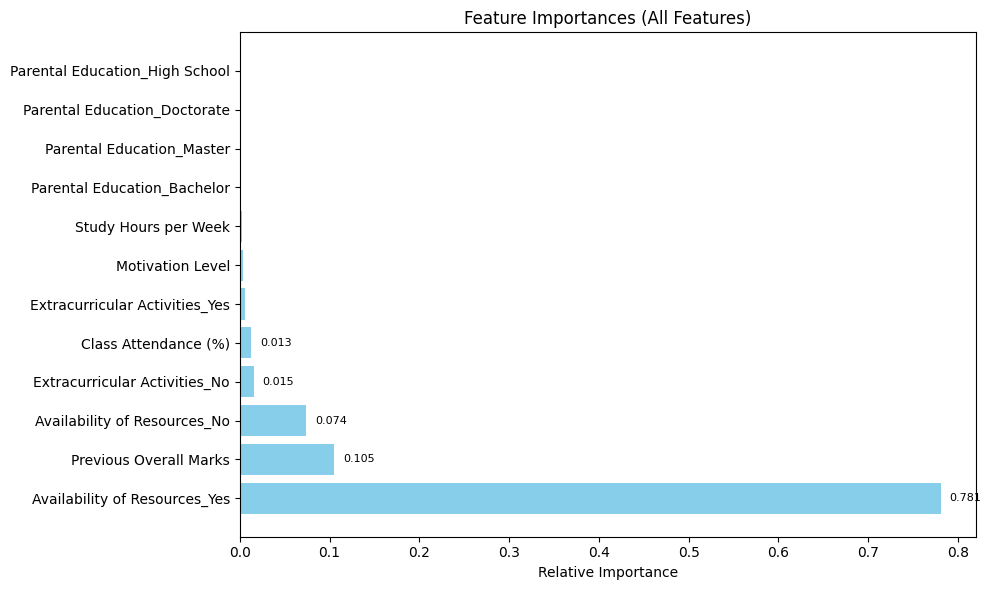

                       Feature   Importance
 Availability of Resources_Yes 7.805679e-01
        Previous Overall Marks 1.048588e-01
  Availability of Resources_No 7.369411e-02
 Extracurricular Activities_No 1.543164e-02
          Class Attendance (%) 1.270380e-02
Extracurricular Activities_Yes 6.186241e-03
              Motivation Level 3.436659e-03
          Study Hours per Week 2.564745e-03
   Parental Education_Bachelor 5.256194e-04
     Parental Education_Master 3.044440e-05
  Parental Education_Doctorate 1.166308e-07
Parental Education_High School 0.000000e+00


In [18]:
# Ensure the pipeline is fitted before accessing feature importances
if not hasattr(best_pipe.named_steps['model'], "feature_importances_"):
    best_pipe.fit(X_train, y_train)

# Get feature importances and names
importances = best_pipe.named_steps['model'].feature_importances_
num_names = num_features
cat_names = best_pipe.named_steps['pre'].named_transformers_['cat'].get_feature_names_out(cat_features)
feature_names = list(num_names) + list(cat_names)

# Sort features by importance
indices = np.argsort(importances)[::-1]
sorted_features = [feature_names[i] for i in indices]
sorted_importances = importances[indices]

# Create visualization with all features
plt.figure(figsize=(10, max(6, len(feature_names) * 0.25)))  # Dynamic height based on number of features
bars = plt.barh(range(len(feature_names)), sorted_importances, color='skyblue')
plt.yticks(range(len(feature_names)), sorted_features)
plt.xlabel('Relative Importance')
plt.title('Feature Importances (All Features)')

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, sorted_importances)):
    if value > 0.01:  # Only label significant values to avoid clutter
        plt.text(bar.get_width() + 0.01, i, f'{value:.3f}', 
                va='center', fontsize=8)

plt.tight_layout()
plt.savefig("plots/all_feature_importances.png", dpi=300, bbox_inches='tight')
plt.show()

# Also create a summary table
importance_df = pd.DataFrame({
    'Feature': sorted_features,
    'Importance': sorted_importances
})
print(importance_df.to_string(index=False))

In [19]:
# After training the model
best_pipe.fit(X_train, y_train)

# Define model output path
MODEL_OUT = "models/student_future_grade_model.pkl"

# Save the fitted model
os.makedirs("models", exist_ok=True)
joblib.dump(best_pipe, MODEL_OUT)

['models/student_future_grade_model.pkl']

In [21]:
from joblib import dump
pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', best_pipe.named_steps['model'])  # Get the trained model from best_pipe
])
dump(pipeline, 'student_marks_pipeline.joblib')


['student_marks_pipeline.joblib']

In [22]:
# Save model
os.makedirs("models", exist_ok=True)
MODEL_OUT = "models/student_future_grade_model.pkl"
joblib.dump(best_pipe, MODEL_OUT)
print(f"Model saved as {MODEL_OUT}")

Model saved as models/student_future_grade_model.pkl


In [23]:
# Verify the model is fitted
y_pred = best_pipe.predict(X_test)
print("Model verification successful!")

Model verification successful!


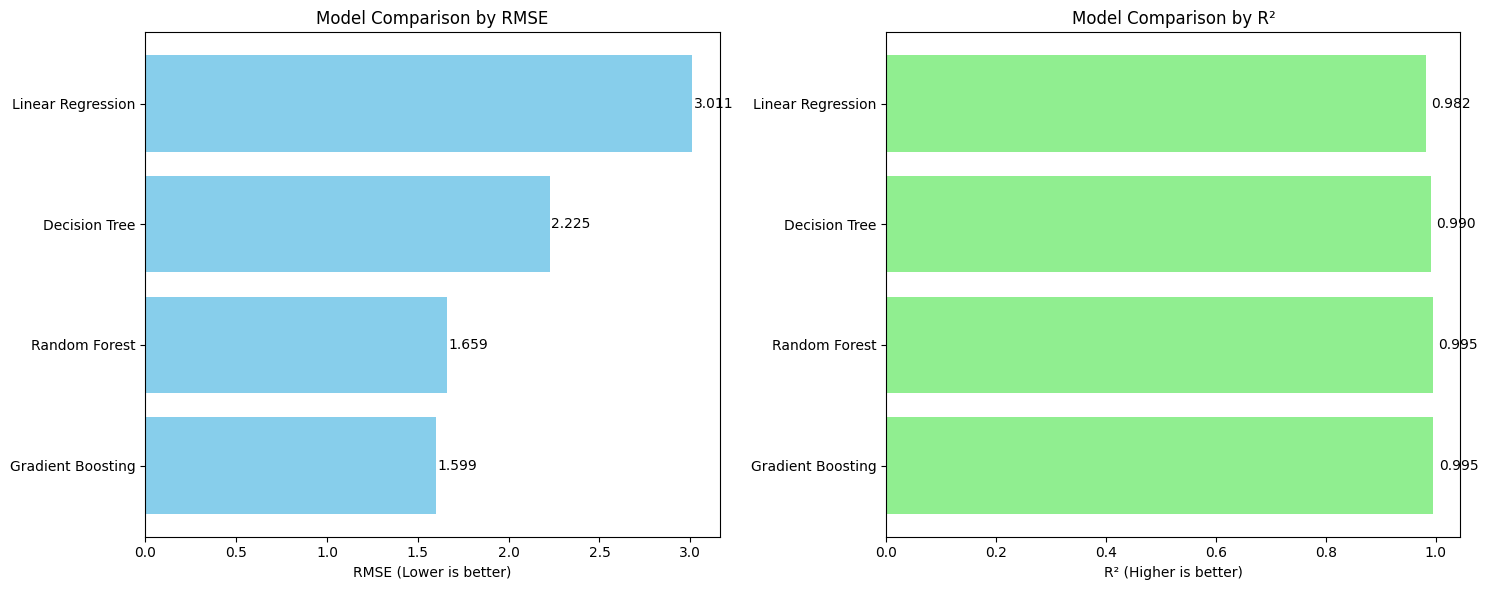

In [24]:
# Create visualizations
os.makedirs("plots", exist_ok=True)

# Model comparison
model_names = list(results.keys())
rmse_scores = [results[name]["RMSE"] for name in model_names]
r2_scores = [results[name]["R2"] for name in model_names]

results_df = pd.DataFrame({
    'Model': model_names,
    'RMSE': rmse_scores,
    'R2': r2_scores
}).sort_values('RMSE')

# Plot model comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# RMSE comparison
bars = ax1.barh(range(len(results_df)), results_df['RMSE'], color='skyblue')
ax1.set_yticks(range(len(results_df)))
ax1.set_yticklabels(results_df['Model'])
ax1.set_xlabel('RMSE (Lower is better)')
ax1.set_title('Model Comparison by RMSE')
for i, bar in enumerate(bars):
    ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{results_df["RMSE"].iloc[i]:.3f}', ha='left', va='center')

# R² comparison
bars = ax2.barh(range(len(results_df)), results_df['R2'], color='lightgreen')
ax2.set_yticks(range(len(results_df)))
ax2.set_yticklabels(results_df['Model'])
ax2.set_xlabel('R² (Higher is better)')
ax2.set_title('Model Comparison by R²')
for i, bar in enumerate(bars):
    ax2.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{results_df["R2"].iloc[i]:.3f}', ha='left', va='center')

plt.tight_layout()
plt.savefig("plots/model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

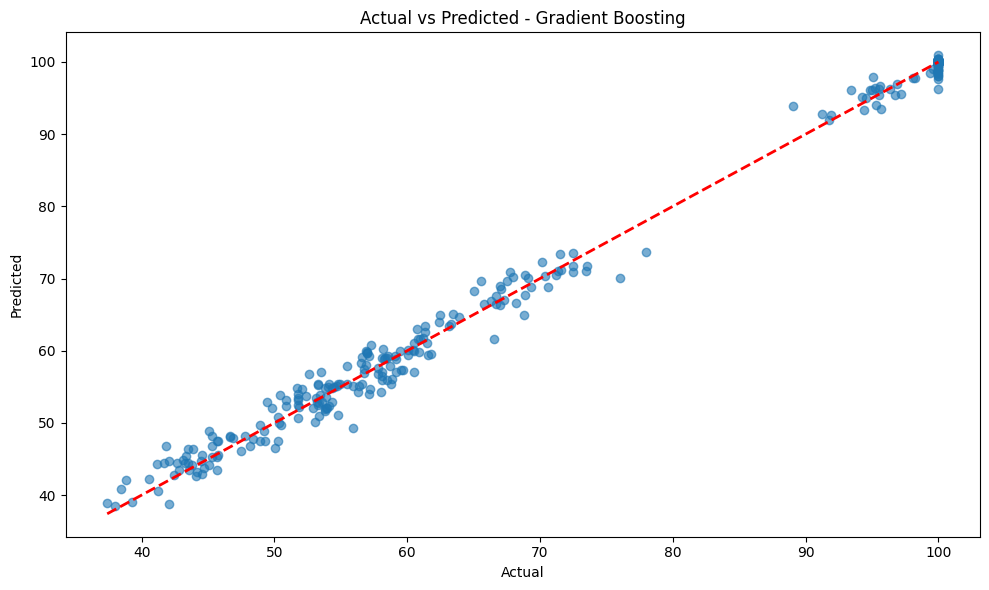

In [25]:
# Make predictions using the best model
y_pred = best_pipe.predict(X_test)

# Actual vs Predicted plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Actual vs Predicted - {best_name}")
plt.tight_layout()
plt.savefig("plots/actual_vs_predicted.png", dpi=300, bbox_inches='tight')
plt.show()

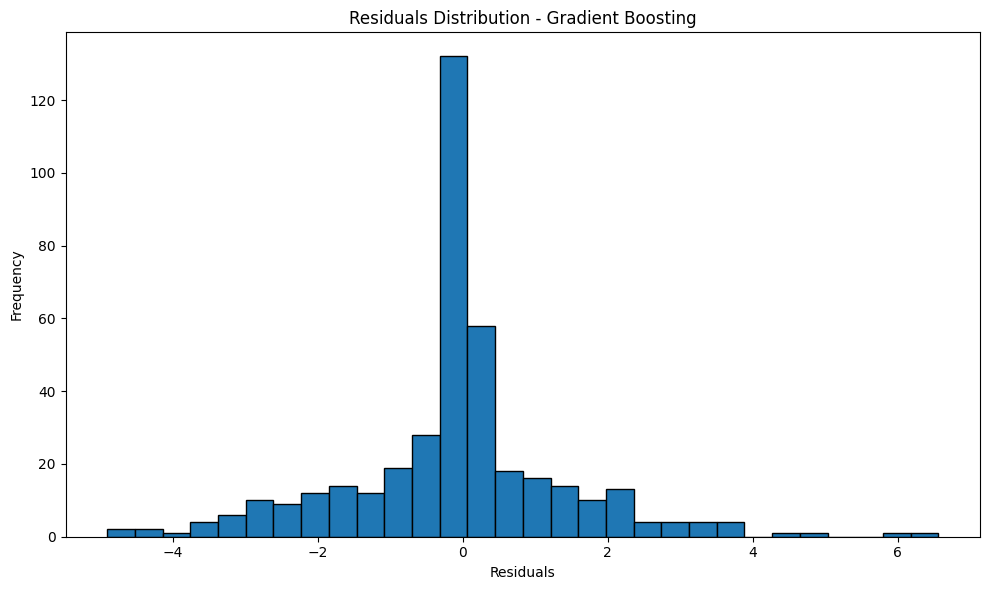

In [ ]:
# Residuals plot
plt.figure(figsize=(10, 6))
residuals = y_test - y_pred
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title(f"Residuals Distribution - {best_name}")
plt.tight_layout()
plt.savefig("plots/residuals_hist.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Save results to CSV
results_df.to_csv("model_comparison_results.csv", index=False)
print("Model comparison results saved to model_comparison_results.csv")
print("\nTraining completed! The best model is:", best_name)

Model comparison results saved to model_comparison_results.csv

Training completed! The best model is: Gradient Boosting


## Verify Model Fitting

In [ ]:
for name, model in models.items():
    model.fit(X_train, y_train)
    if hasattr(model, 'n_features_in_'):
        print(f"{name} is fitted.")
    else:
        print(f"{name} is NOT fitted.")



Linear Regression is fitted.
Random Forest is fitted.
Decision Tree is fitted.
Gradient Boosting is fitted.
